In [33]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,classification_report,accuracy_score, f1_score,confusion_matrix, roc_auc_score,ConfusionMatrixDisplay

# PART1 : **Language Modeling / Regression**

In [2]:
df = pd.read_csv('https://github.com/dbbrandt/short_answer_granding_capstone_project/raw/master/data/sag/answers.csv')
df.head()

,id,answer,score,correct
0,1.1,High risk problems are address in the prototyp...,3.5,0.0
1,1.1,To simulate portions of the desired final prod...,5.0,1.0
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0
4,1.1,It is used to let the users have a first idea ...,3.0,0.0


### Text Cleaning and Preprocessing

In [3]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert text to lowercase
        text = re.sub(r'\W', ' ', text)  # Remove non-word characters
        text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    else:
        text = ''  # Handle non-string input by converting to empty string
    return text

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]
    
df['cleaned_answer'] = df['answer'].apply(preprocess_text)
df.head()

,id,answer,score,correct,cleaned_answer
0,1.1,High risk problems are address in the prototyp...,3.5,0.0,high risk problems are address in the prototyp...
1,1.1,To simulate portions of the desired final prod...,5.0,1.0,to simulate portions of the desired final prod...
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0,a prototype program simulates the behaviors of...
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0,defined in the specification phase a prototype...
4,1.1,It is used to let the users have a first idea ...,3.0,0.0,it is used to let the users have a first idea ...


###  Tokenization, stop words removal, and lemmatization

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
df['tokens'] = df['cleaned_answer'].apply(tokenize)
df['tokens'] = df['tokens'].apply(remove_stopwords)
df['tokens'] = df['tokens'].apply(lemmatize)
df

,id,answer,score,correct,cleaned_answer,tokens
0,1.1,High risk problems are address in the prototyp...,3.5,0.0,high risk problems are address in the prototyp...,"[high, risk, problem, address, prototype, prog..."
1,1.1,To simulate portions of the desired final prod...,5.0,1.0,to simulate portions of the desired final prod...,"[simulate, portion, desired, final, product, q..."
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0,a prototype program simulates the behaviors of...,"[prototype, program, simulates, behavior, port..."
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0,defined in the specification phase a prototype...,"[defined, specification, phase, prototype, sti..."
4,1.1,It is used to let the users have a first idea ...,3.0,0.0,it is used to let the users have a first idea ...,"[used, let, user, first, idea, completed, prog..."
...,...,...,...,...,...,...
2437,12.1,log n,5.0,1.0,log n,"[log, n]"
2438,12.1,minus 1 divided by 2,1.5,0.0,minus 1 divided by 2,"[minus, 1, divided, 2]"
2439,12.1,2n-1,2.5,0.0,2n 1,"[2n, 1]"
2440,12.1,"it takes at most h steps, where h is the heigh...",5.0,1.0,it takes at most h steps where h is the height...,"[take, h, step, h, height, tree]"


## Word Embedding :

### Word2Vec Embedding

In [6]:
df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, sg=0)
# Generate Word2Vec embeddings for each answer
def get_avg_word2vec(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return [0] * vector_size
    else:
        return np.mean(vectors, axis=0)

df['word2vec'] = df['tokens'].apply(lambda x: get_avg_word2vec(x, word2vec_model, 100))

### Bag of Words (BoW)

In [7]:
#CountVectorizer : Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
# fit & transform will represent each sentences as BOW representation
BOW = count_vect.fit_transform(df['processed_text'])
# Convert to DataFrame for readability
bow_df = pd.DataFrame(BOW.toarray(), columns=count_vect.get_feature_names_out())

### TF-IDF

In [8]:
# TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['processed_text'])
# Convert to DataFrame for readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df

,id,answer,score,correct,cleaned_answer,tokens,processed_text,word2vec
0,1.1,High risk problems are address in the prototyp...,3.5,0.0,high risk problems are address in the prototyp...,"[high, risk, problem, address, prototype, prog...",high risk problem address prototype program ma...,"[-0.062628634, 0.2310279, 0.20052093, 0.131976..."
1,1.1,To simulate portions of the desired final prod...,5.0,1.0,to simulate portions of the desired final prod...,"[simulate, portion, desired, final, product, q...",simulate portion desired final product quick e...,"[-0.049643647, 0.18079025, 0.15378647, 0.10098..."
2,1.1,A prototype program simulates the behaviors of...,4.0,1.0,a prototype program simulates the behaviors of...,"[prototype, program, simulates, behavior, port...",prototype program simulates behavior portion d...,"[-0.053711306, 0.19835444, 0.17079805, 0.10989..."
3,1.1,Defined in the Specification phase a prototype...,5.0,1.0,defined in the specification phase a prototype...,"[defined, specification, phase, prototype, sti...",defined specification phase prototype stimulat...,"[-0.05189281, 0.18645594, 0.16027167, 0.104846..."
4,1.1,It is used to let the users have a first idea ...,3.0,0.0,it is used to let the users have a first idea ...,"[used, let, user, first, idea, completed, prog...",used let user first idea completed program all...,"[-0.0424904, 0.16227338, 0.13729529, 0.0906302..."
...,...,...,...,...,...,...,...,...
2437,12.1,log n,5.0,1.0,log n,"[log, n]",log n,"[-0.07435466, 0.15510653, 0.14622065, 0.120482..."
2438,12.1,minus 1 divided by 2,1.5,0.0,minus 1 divided by 2,"[minus, 1, divided, 2]",minus 1 divided 2,"[-0.077751786, 0.2193637, 0.18874297, 0.148487..."
2439,12.1,2n-1,2.5,0.0,2n 1,"[2n, 1]",2n 1,"[-0.059242386, 0.1795503, 0.15395692, 0.110506..."
2440,12.1,"it takes at most h steps, where h is the heigh...",5.0,1.0,it takes at most h steps where h is the height...,"[take, h, step, h, height, tree]",take h step h height tree,"[-0.06515992, 0.23860396, 0.19820057, 0.131388..."


### Model Training and Evaluation

In [9]:
X = list(df['word2vec'])
y = df['score']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)

### SVR :

In [11]:
SVR = SVR()
SVR.fit(X_train, y_train)
SVR_predictions = SVR.predict(X_test)
SVR_mse = mean_squared_error(y_test, SVR_predictions)
SVR_rmse = np.sqrt(SVR_mse)

### Linear Regression :

In [12]:
LR = LinearRegression()
LR.fit(X_train, y_train)
LR_predictions = LR.predict(X_test)
LR_mse = mean_squared_error(y_test, LR_predictions)
LR_rmse = np.sqrt(LR_mse)

### Decision Tree :

In [13]:
DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)
DT_predictions = DT.predict(X_test)
DT_mse = mean_squared_error(y_test, DT_predictions)
DT_rmse = np.sqrt(DT_mse)

### Naive Bayes :

In [14]:
y_dis = pd.qcut(y, q=4, labels=False, duplicates='drop') # Discretize into 4 quantiles
X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(X, y_dis, test_size=0.2, random_state=42)
X_train_dis = np.array(X_train_dis)
X_test_dis = np.array(X_test_dis)

NB = GaussianNB()
NB.fit(X_train_dis, y_train_dis)
NB_predictions = NB.predict(X_test_dis)

NB_mse = mean_squared_error(y_test, NB_predictions)
NB_rmse = np.sqrt(NB_mse)

In [15]:
print(f"SVR_mse: {SVR_mse:.4f}, SVR_rmse: {SVR_rmse:.4f}")
print(f"NB_mse: {NB_mse:.4f}, SVR_rmse: {NB_rmse:.4f}")
print(f"LR_mse: {LR_mse:.4f}, SVR_rmse: {LR_rmse:.4f}")
print(f"DT_mse: {DT_mse:.4f}, SVR_rmse: {DT_rmse:.4f}")

SVR_mse: 1.7335, SVR_rmse: 1.3166
NB_mse: 12.1828, SVR_rmse: 3.4904
LR_mse: 1.2779, SVR_rmse: 1.1304
DT_mse: 1.8704, SVR_rmse: 1.3676


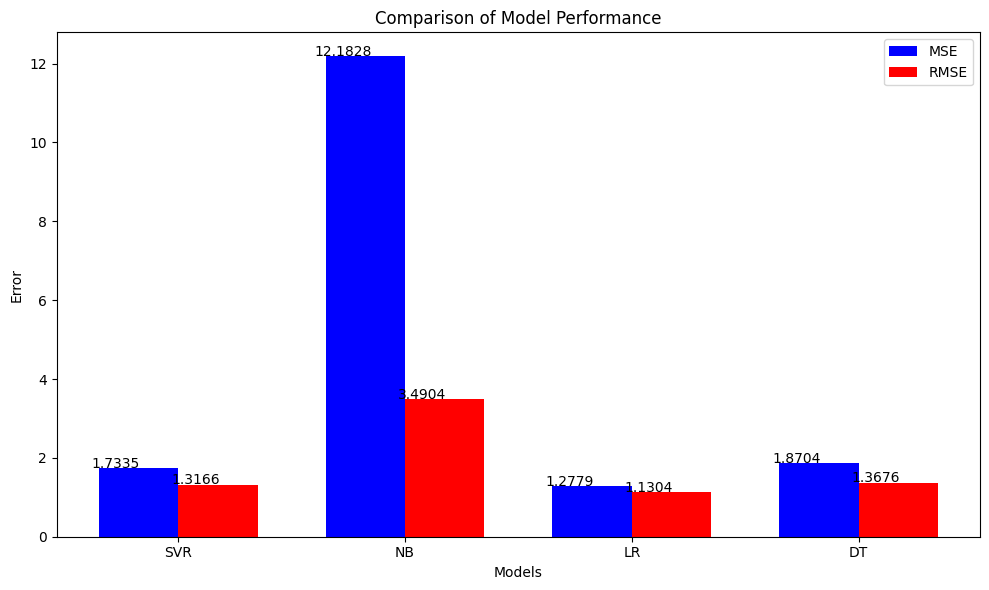

In [16]:
# Define the names and results for each model
model_names = ["SVR", "NB", "LR", "DT"]
mse_values = [SVR_mse, NB_mse, LR_mse, DT_mse]
rmse_values = [SVR_rmse, NB_rmse, LR_rmse, DT_rmse]

# Number of models
n_models = len(model_names)

# Positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(n_models)

# Plotting
plt.figure(figsize=(10, 6))

# Plot MSE bars
plt.bar(index, mse_values, bar_width, color='blue', label='MSE')

# Plot RMSE bars next to MSE bars
plt.bar(index + bar_width, rmse_values, bar_width, color='RED', label='RMSE')

# Adding labels
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Comparison of Model Performance')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()

# Adding text annotations for MSE values
for i, v in enumerate(mse_values):
    plt.text(i - 0.1, v + 0.01, f'{v:.4f}', ha='center')

# Adding text annotations for RMSE values
for i, v in enumerate(rmse_values):
    plt.text(i + bar_width - 0.1, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

## Conclusion :

### In conclusion, Linear Regression is the preferred choice for predictive modeling on this dataset based on the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), it shows the lowest MSE and RMSE values. This implies that its predictions align most closely with the actual values.However,it's important to also consider other aspects such as model assumptions, computational efficiency, and interpretability when finalizing the model choice.

# PART2 : **Language Modeling / Classification**

In [17]:
df1 = pd.read_csv("twitter.csv")
df1.columns = ['ID', 'Entity', 'Sentiment', 'Text']
print(df1.head())

     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


In [19]:
df1['cleaned_text'] = df1['Text'].apply(preprocess_text)
df1['tokens'] = df1['cleaned_text'].apply(tokenize)
df1['tokens'] = df1['tokens'].apply(remove_stopwords)
df1['tokens'] = df1['tokens'].apply(lemmatize)

## **Encode Data Vectors**

In [20]:
word2vec_model = Word2Vec(sentences=df1['tokens'], vector_size=100, window=5, min_count=1, sg=0)

# Function to get word embeddings
def get_word_embedding(tokens, model):
    embeddings = []
    for word in tokens:
        if word in model.wv:
            embeddings.append(model.wv[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no embeddings found

# Apply word embeddings
df1_word2vec = df1['tokens'].apply(lambda x: get_word_embedding(x, word2vec_model))

### Bag of Words

In [21]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df1['cleaned_text'])

### TF-IDF

In [22]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df1['cleaned_text'])


# **Train Models**

In [23]:
X = np.vstack(df1_word2vec)
y = df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.5247372296980652


In [25]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 357  792  703  809]
 [ 131 3106  650  584]
 [ 115  818 1917  701]
 [ 148  804  844 2458]]


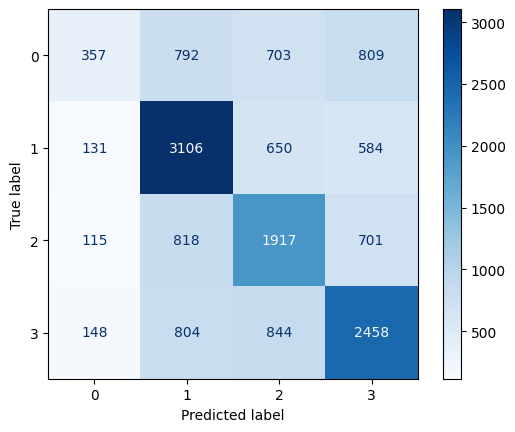

In [26]:
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.show()

In [27]:
print("Classification Report for Naive Bayes:")
print(classification_report(y_test, svm_pred))

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

  Irrelevant       0.48      0.13      0.21      2661
    Negative       0.56      0.69      0.62      4471
     Neutral       0.47      0.54      0.50      3551
    Positive       0.54      0.58      0.56      4254

    accuracy                           0.52     14937
   macro avg       0.51      0.49      0.47     14937
weighted avg       0.52      0.52      0.50     14937



In [28]:
# Naive Bayes classifier
NBC = GaussianNB()
NBC.fit(X_train, y_train)
NBP = NBC.predict(X_test)
NB_acc = accuracy_score(y_test, NBP)
print("Naive Bayes Accuracy:", NB_acc)

Naive Bayes Accuracy: 0.45477672892816495


In [29]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, NBP)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1105  722  400  434]
 [ 830 2584  550  507]
 [ 930  654 1446  521]
 [1210  816  570 1658]]


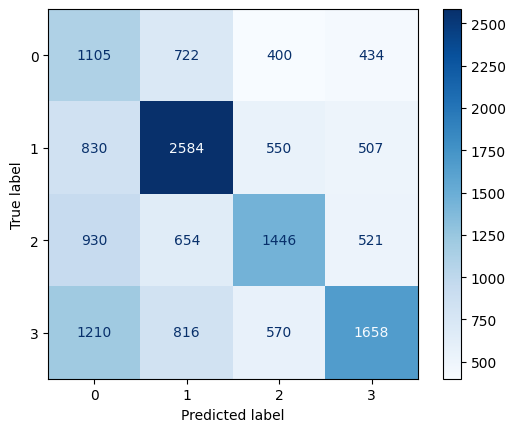

In [30]:
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.show()

In [31]:
print("Classification Report for Naive Bayes:")
print(classification_report(y_test, NBP))

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

  Irrelevant       0.27      0.42      0.33      2661
    Negative       0.54      0.58      0.56      4471
     Neutral       0.49      0.41      0.44      3551
    Positive       0.53      0.39      0.45      4254

    accuracy                           0.45     14937
   macro avg       0.46      0.45      0.45     14937
weighted avg       0.48      0.45      0.46     14937



In [36]:
LGR = LogisticRegression(max_iter=1000)
LGR.fit(X_train, y_train)
LGRP = LGR.predict(X_test)
LGR_acc = accuracy_score(y_test, LGRP)
print("Logistic Regression Accuracy:", LGR_acc)

Logistic Regression Accuracy: 0.5240677512217983


In [41]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, LGRP)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 419  773  662  807]
 [ 158 3061  656  596]
 [ 121  817 1906  707]
 [ 172  799  841 2442]]


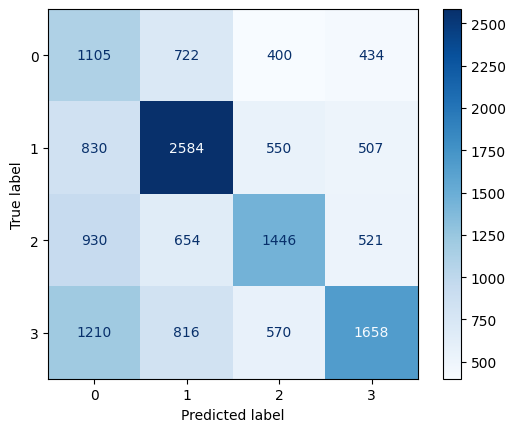

In [39]:
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.show()

In [45]:
print("Classification Report for LGR:")
print(classification_report(y_test, LGRP))

Classification Report for LGR:
              precision    recall  f1-score   support

  Irrelevant       0.48      0.16      0.24      2661
    Negative       0.56      0.68      0.62      4471
     Neutral       0.47      0.54      0.50      3551
    Positive       0.54      0.57      0.55      4254

    accuracy                           0.52     14937
   macro avg       0.51      0.49      0.48     14937
weighted avg       0.52      0.52      0.50     14937



In [46]:
adaboost = AdaBoostClassifier(n_estimators=100)
adaboost.fit(X_train, y_train)
adaboostP = adaboost.predict(X_test)
adaboost_accuracy = accuracy_score(y_test, adaboostP)
print("AdaBoost Accuracy:", adaboost_accuracy)

AdaBoost Accuracy: 0.5069291022293633


In [47]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, adaboost_accuracy)
print("Confusion Matrix:")
print(conf_matrix)

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0.5069291022293633 instead.

In [ ]:
# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
print("Classification Report for adaboost:")
print(classification_report(y_test, adaboost_accuracy))

In [ ]:
# Assuming you have calculated accuracy scores for each model
models = ['SVM', 'Naive Bayes', 'Logistic Regression', 'AdaBoost']
accuracies = [svm_accuracy, NB_acc, LGR_acc, adaboost_accuracy]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='red')
plt.title('Accuracy Scores of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to range between 0 and 1
plt.show()


## Model Comparison and Interpretation


Logistic Regression and SVM outperform Naive Bayes and AdaBoost in terms of accuracy and overall classification metrics. Despite lower accuracy scores, AdaBoost and Naive Bayes offer valuable insights, particularly in classifying majority classes.

## Conclusion

Logistic Regression and SVM exhibit higher accuracy and classification metrics compared to Naive Bayes and AdaBoost. However, AdaBoost and Naive Bayes provide valuable insights, especially in classifying majority classes.
- Consider task-specific requirements and the balance between precision, recall, and accuracy when selecting the best model for deployment.